# <h1><b><I> General Setup

## Imports and general setup

In [2]:
import os, sys, time
from tqdm import tqdm
sys.path.append("gammabayes/BFCalc/")
sys.path.append("gammabayes")

# from gammabayes.BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from gammabayes.likelihoods.instrument_response_funcs import log_bkg_CCR_dist, log_edisp, log_psf, single_loglikelihood
from scipy import interpolate, special, integrate
from gammabayes.utils.event_axes import log10eaxistrue, longitudeaxistrue, latitudeaxistrue, log10eaxis, longitudeaxis, latitudeaxis, makelogjacob
# from gammabayes.utils.utils import inverse_transform_sampling
from gammabayes.hyper_inference.hyperparameter_likelihood import hyperparameter_likelihood
from gammabayes.priors.prior import discrete_logprior
from gammabayes.likelihoods.likelihood import discrete_loglikelihood
from gammabayes.dark_matter.SS_DM_Constructor import SS_DM_dist

from gammabayes.utils.utils import bin_centres_to_edges
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools, random
from multiprocessing import Pool, freeze_support
import multiprocessing
import pandas as pd
random.seed(0)

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
astrophysicalbackground = np.load("gammabayes/package_data/unnormalised_astrophysicalbackground.npy")
psfnormalisationvalues = np.load("gammabayes/package_data/psfnormalisation.npy")
edispnormalisationvalues = np.load("gammabayes/package_data/edispnormalisation.npy")


In [4]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

logjacobtrue = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]


print(lonmeshtrue.shape, lonmeshrecon.shape)

(301, 35, 30) (35, 30)


## Script Parameter Setup

In [10]:
numberoftruevaluesamples = int(1e3)
Nsamples=numberoftruevaluesamples
truelambda          = 0.5
nsig                = int(round(truelambda*Nsamples))
nbkg                = int(round((1-truelambda)*Nsamples))

truelambda          = nsig/(nbkg+nsig)
numcores            = 8
truelogmass         = 0.48

startertimer = time.perf_counter()
print(startertimer)

110.318981791


# <h1><b>Simulation

## Setup

### Background setup

In [11]:
unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(log_bkg_CCR_dist(log10emeshtrue, lonmeshtrue,latmeshtrue)),np.log(astrophysicalbackground))


logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues+logjacobtrue)

logbkgpriorvalues.shape


nuisancemesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(log_bkg_CCR_dist(*nuisancemesh)),np.log(astrophysicalbackground))
# unnormed_logbkgpriorvalues = np.squeeze(log_bkg_CCR_dist(*nuisancemesh))


logbkgfunc_annoying = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(unnormed_logbkgpriorvalues))
logbkgfunc = lambda logenergy, longitude, latitude: np.log(logbkgfunc_annoying((logenergy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)

### Signal Setup

In [12]:
SS_DM_dist_instance= SS_DM_dist(longitudeaxistrue, latitudeaxistrue)
logDMpriorfunc = SS_DM_dist_instance.func_setup()

In [13]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(truelogmass,), hyperparameter_names=['mass'], logjacob=logjacobtrue)
DM_prior

(0.48,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x7ff76884dee0>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

## True Value Simulation

In [14]:
if truelambda!=0.0:
    siglogevals,siglonvals,siglatvals  = DM_prior.sample(nsig)
else:
    siglogevals = np.asarray([])
    siglonvals = np.asarray([])
    siglatvals = np.asarray([])

In [15]:

if truelambda!=1.0:
    bkglogevals,bkglonvals,bkglatvals  = bkg_prior.sample(nbkg)
else:
    bkglogevals = np.asarray([])
    bkglonvals = np.asarray([])
    bkglatvals = np.asarray([])

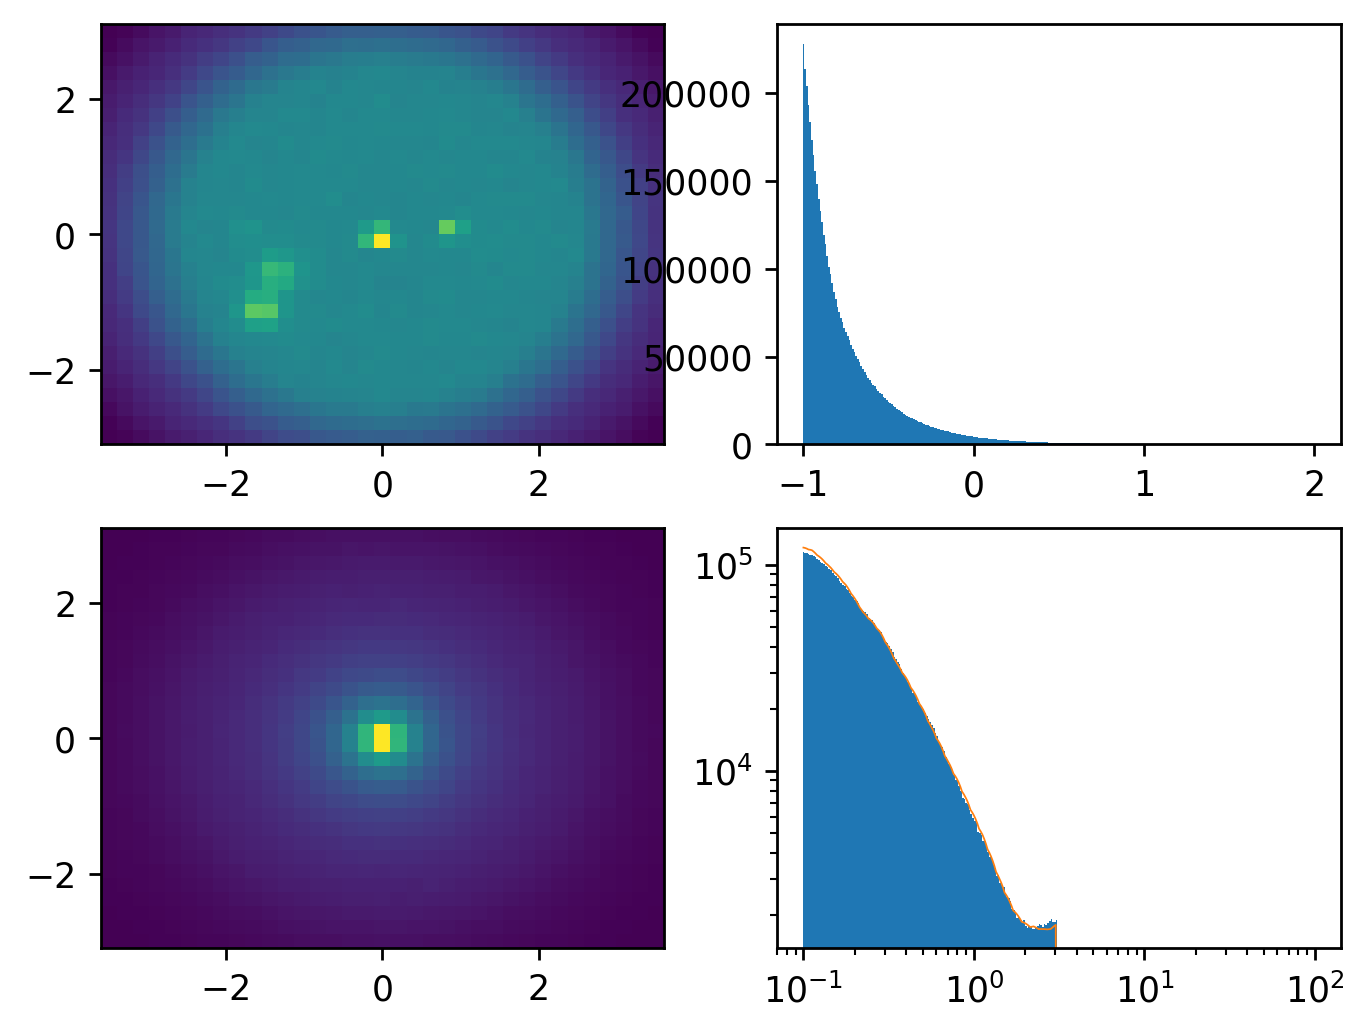

In [21]:
plt.figure(dpi=250)
plt.subplot(221)
plt.hist2d(bkglonvals, bkglatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)))

plt.subplot(222)
plt.hist(bkglogevals, bins=bin_centres_to_edges(log10eaxistrue))

plt.subplot(223)
plt.hist2d(siglonvals,siglatvals, bins=(bin_centres_to_edges(longitudeaxistrue), bin_centres_to_edges(latitudeaxistrue)))


plt.subplot(224)
sigtrue_histvals = plt.hist(10**siglogevals, bins=bin_centres_to_edges(10**log10eaxistrue))
spectralvals = np.exp(logDMpriorfunc(log10eaxistrue, log10eaxistrue*0.0, log10eaxistrue*0.0, log10eaxistrue*0.0+truelogmass)+makelogjacob(log10eaxistrue))
plt.plot(10**log10eaxistrue,spectralvals/np.percentile(spectralvals, 60)*np.percentile(sigtrue_histvals[0],60), lw=0.5)
plt.loglog()
plt.show()

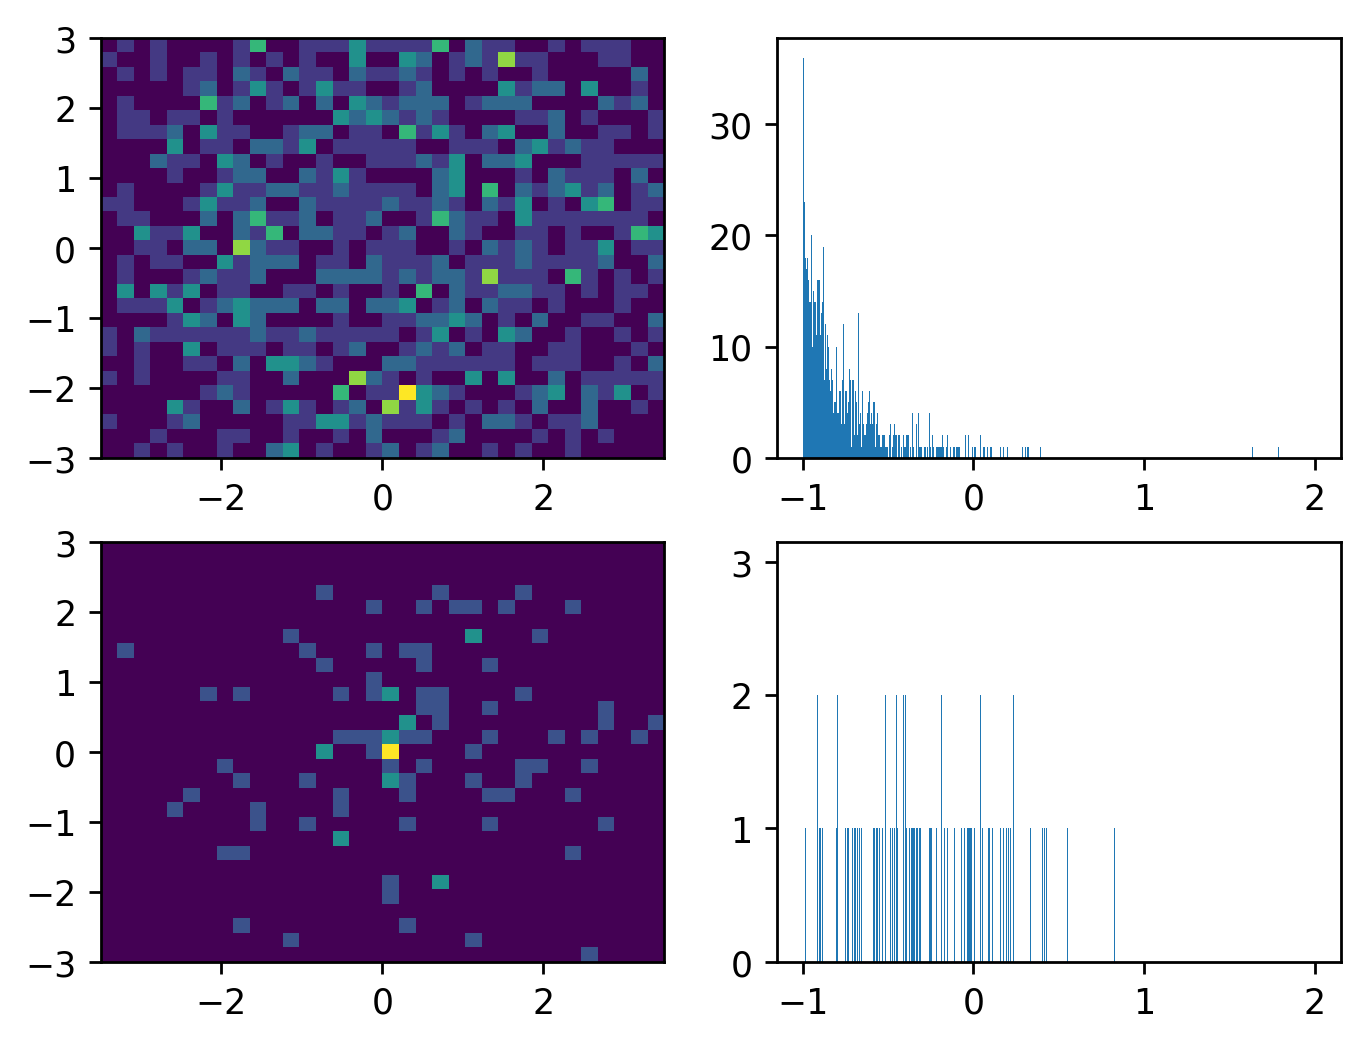

## Reconstructed Value Simulation

In [11]:
logjacob = np.meshgrid(np.log(10**log10eaxis), longitudeaxis, latitudeaxis, indexing='ij')[0]

In [12]:
logjacob = np.log(10**log10eaxis)
edisp_like = discrete_loglikelihood(logfunction=log_edisp, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])

Number of input dimensions 1


In [13]:
psf_like = discrete_loglikelihood(logfunction=log_psf, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function log_psf at 0x7fbb4b6af040>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

### Signal

In [14]:

if truelambda!=0.0:
    # sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    signal_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
else:
    signal_log10e_measured = np.asarray([])

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:00<00:00, 1473.88it/s]


In [15]:

signal_lon_measured = []
signal_lat_measured = []

if truelambda!=0:
    
    sig_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    
    for sig_lonlat_psf_sample in sig_lonlat_psf_samples:
        signal_lon_measured.append(sig_lonlat_psf_sample[0])
        signal_lat_measured.append(sig_lonlat_psf_sample[1])

100%|██████████| 400/400 [00:02<00:00, 155.37it/s]


### Background

In [16]:
if truelambda!=1.0:
    # sig_log10e_edisp_samples = [edisp_like.sample(signal_event_tuple, 1).tolist() for signal_event_tuple in tqdm(sig_samples.T)]
    bkg_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]
else:
    bkg_log10e_measured = np.asarray([])

100%|██████████| 39600/39600 [00:25<00:00, 1557.79it/s]


In [17]:
bkg_lon_measured = []
bkg_lat_measured = []

if truelambda!=0:
    
    bkg_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)]
    
    for bkg_lonlat_psf_sample in bkg_lonlat_psf_samples:
        bkg_lon_measured.append(bkg_lonlat_psf_sample[0])
        bkg_lat_measured.append(bkg_lonlat_psf_sample[1])


100%|██████████| 39600/39600 [04:05<00:00, 161.59it/s]


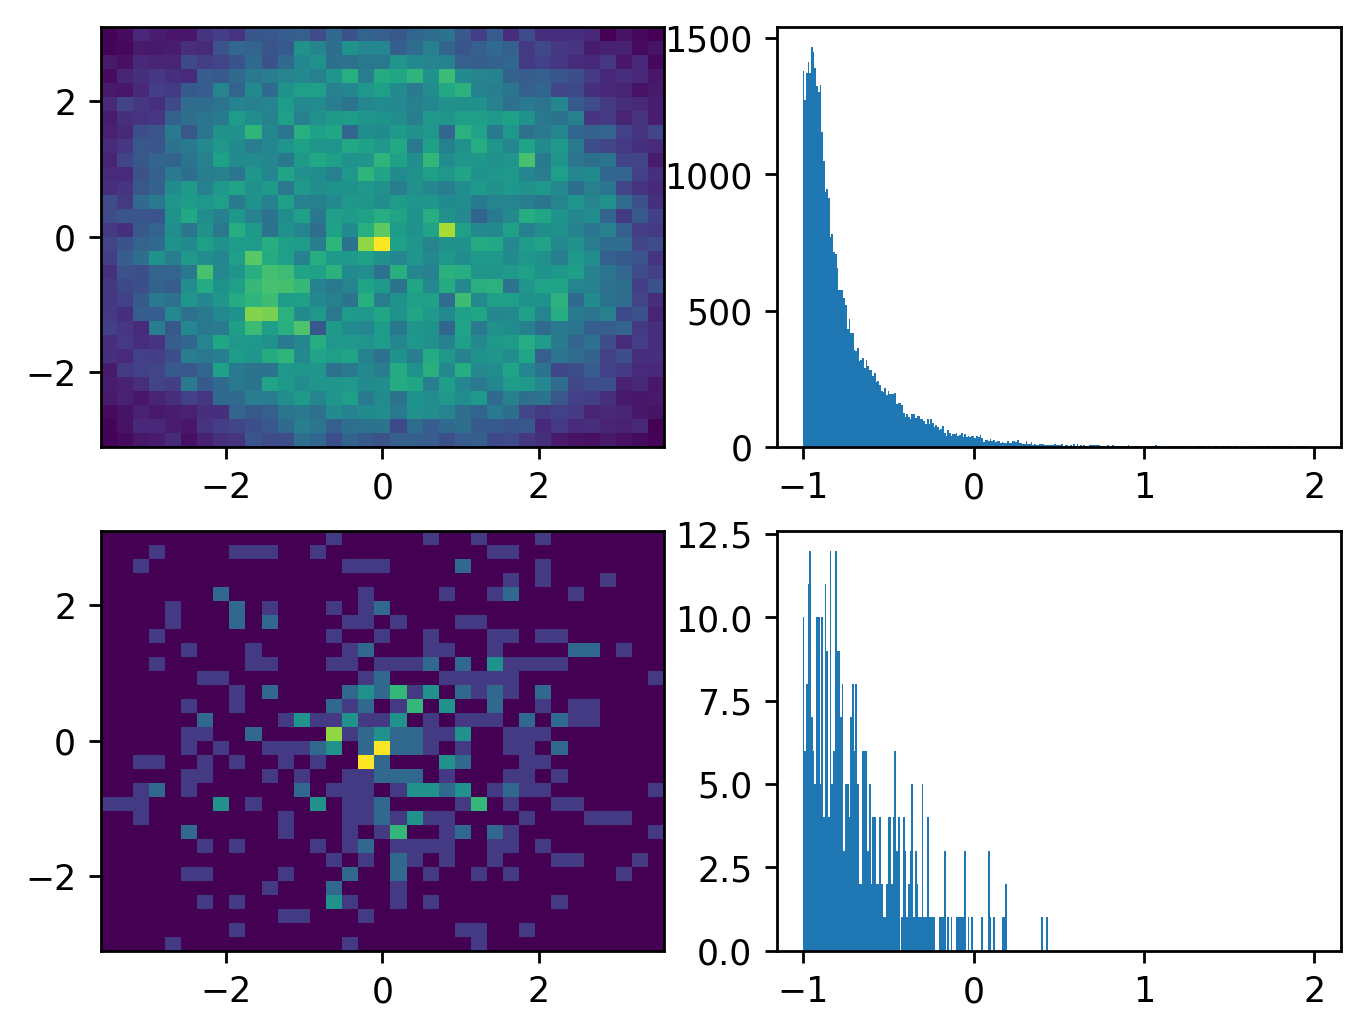

In [18]:
plt.figure(dpi=250)
plt.subplot(221)
plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)))

plt.subplot(222)
plt.hist(bkg_log10e_measured, bins=bin_centres_to_edges(log10eaxis))

plt.subplot(223)
plt.hist2d(signal_lon_measured,signal_lat_measured, bins=(bin_centres_to_edges(longitudeaxis), bin_centres_to_edges(latitudeaxis)))

plt.subplot(224)
plt.hist(signal_log10e_measured, bins=bin_centres_to_edges(log10eaxis))
plt.show()

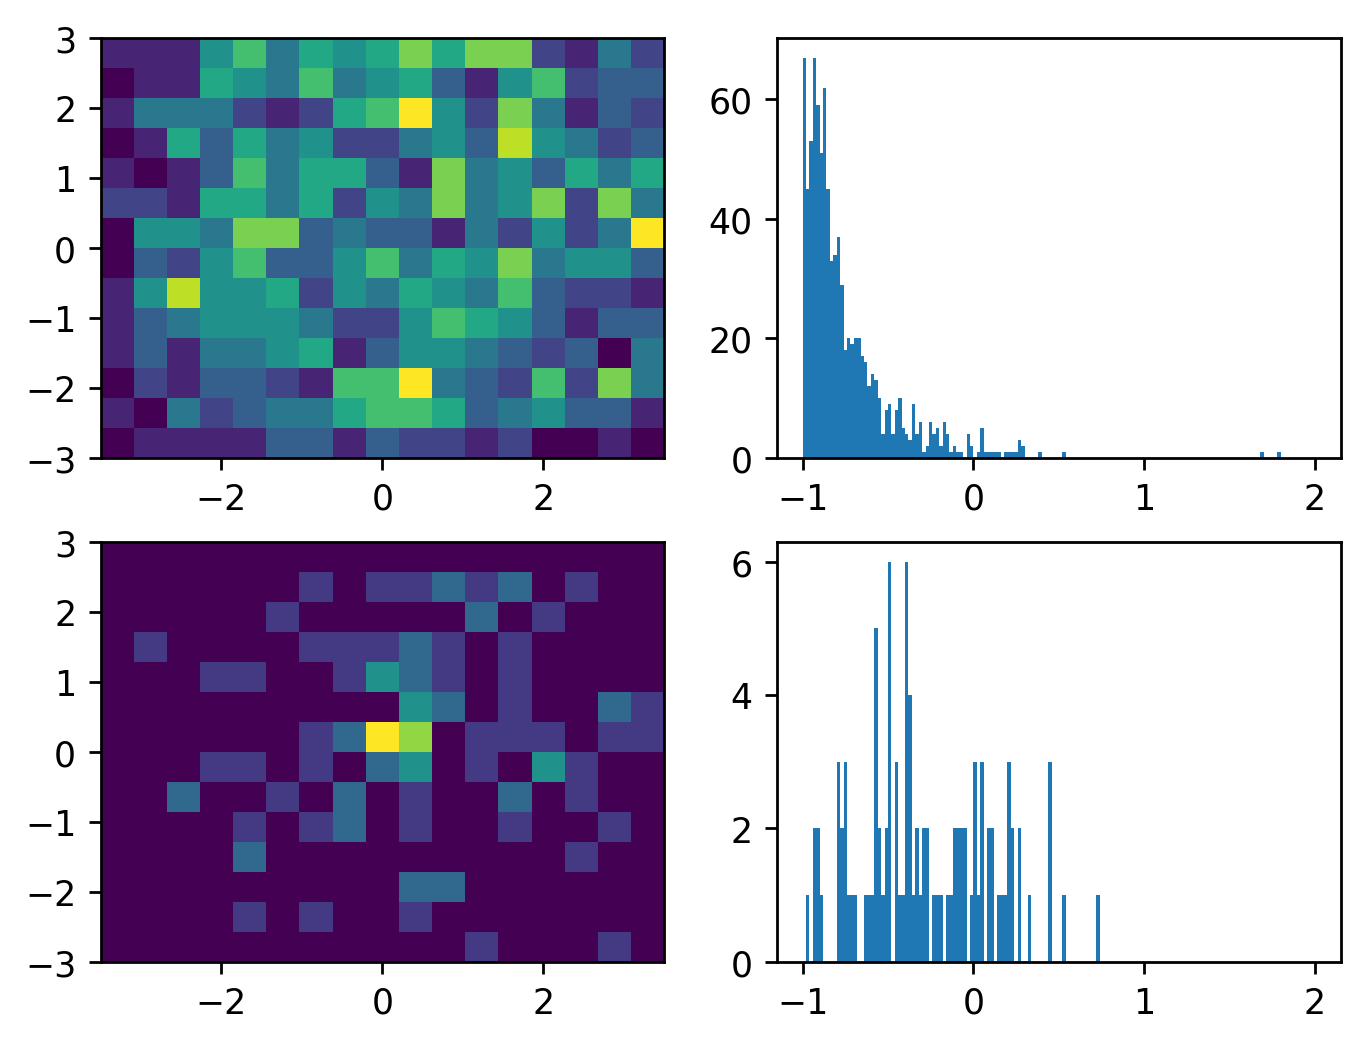

## Final simulation output

In [19]:


try:
    measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
    measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)
    
except:
    if type(bkg_log10e_measured)==np.float64:
        measured_log10e = list(signal_log10e_measured)
        measured_lon = list(signal_lon_measured)
        measured_lat = list(signal_lat_measured)
        measured_log10e.append(bkg_log10e_measured)
        measured_lon.append(bkg_lon_measured)
        measured_lat.append(bkg_lat_measured)
        
    elif type(signal_log10e_measured)==np.float64:
        measured_log10e = list(bkg_log10e_measured)
        measured_lon = list(bkg_lon_measured)
        measured_lat = list(bkg_lat_measured)
        measured_log10e.append(signal_log10e_measured)
        measured_lon.append(signal_lon_measured)
        measured_lat.append(signal_lat_measured)
    else:
        print('what')

# <h1><b>Analysis

## Marginalisation

In [20]:
nbinslogmass=101

if nsig is None:
    nsig = len(list(measured_log10e))

logmasswindowwidth      =6/np.sqrt(nsig)

logmasslowerbound       = truelogmass-logmasswindowwidth
logmassupperbound       = truelogmass+logmasswindowwidth

# if 1:
if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 

In [21]:
hyperparameter_likelihood_instance = hyperparameter_likelihood(priors=(DM_prior, bkg_prior,), likelihood=single_loglikelihood, 
                                                               dependent_axes=(log10eaxistrue,  longitudeaxistrue, latitudeaxistrue), dependent_logjacob=logjacobtrue,
                                                               hyperparameter_axes = ((logmassrange,), (None,)), numcores=numcores, likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)

measured_log10e = [float(measured_log10e_val) for measured_log10e_val in measured_log10e]
margresults = hyperparameter_likelihood_instance.nuisance_log_marginalisation(axisvals= (measured_log10e, measured_lon, measured_lat))

Setting up prior matrices: 100%|██████████| 2/2 [01:15<00:00, 37.92s/it]
Performing parallelized direct event marginalisation: 100%|██████████| 40000/40000 [00:00<00:00, 3217416.05it/s]
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/gammabayes/likelihoods/instrument_response_funcs.py:116: RuntimeWarning: divide by zero encountered in log
  output = np.log(psffull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/gammabayes/likelihoods/instrument_response_funcs.py:120: RuntimeWarning: divide by zero encountered in log
  output+=np.log(edispfull.evaluate(energy_true=10**logetrue*u.TeV,


In [22]:
margresultsarray = np.array(margresults)
sigmargresults = np.squeeze(np.vstack(margresultsarray[:,0])).T
bkgmargresults = np.squeeze(np.vstack(margresultsarray[:,1]))
sigmargresults.shape

(101, 40000)

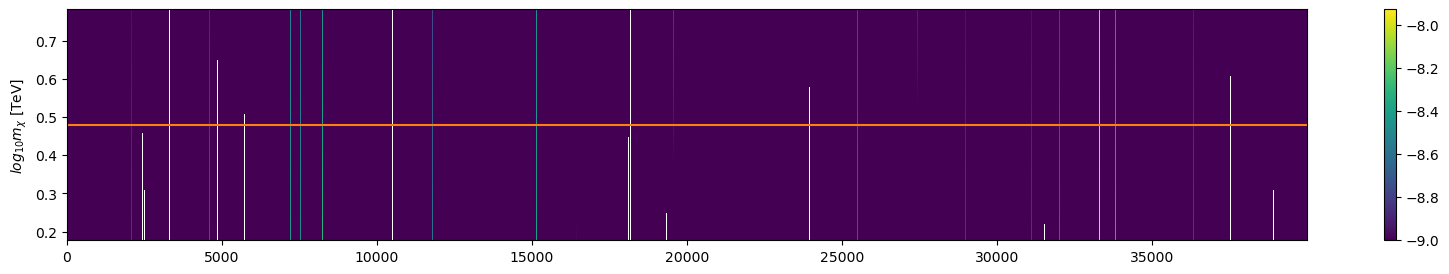

In [23]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(Nsamples)), logmassrange, indexing='ij'), 
               sigmargresults.T-special.logsumexp(sigmargresults, axis=1), 
               cmap='viridis', vmin=-9)
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(truelogmass, c='tab:orange')
plt.colorbar()
plt.show()

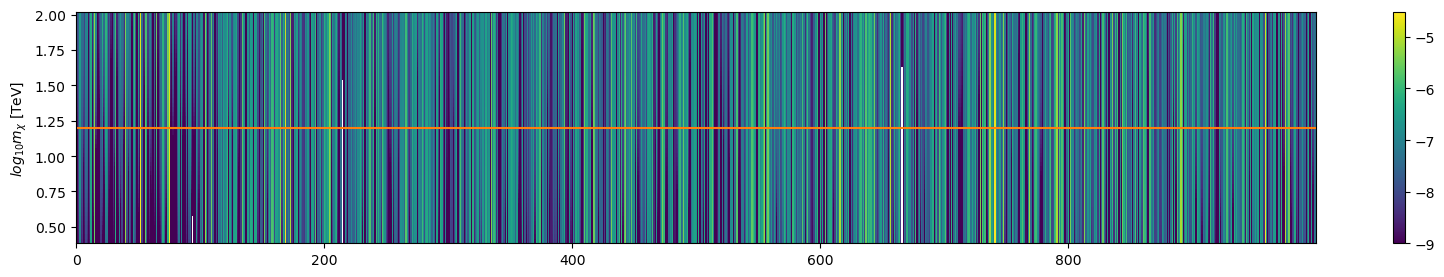

## Calculating posterior

In [24]:

nbinslambda            = 151
lambdawindowwidth      = 9/np.sqrt(Nsamples)


lambdalowerbound       = truelambda-lambdawindowwidth
lambdaupperbound       = truelambda+lambdawindowwidth




if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, nbinslambda) 

original_log_posterior = []

for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
    original_log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+sigmargresults[logmassindex,:], np.log(1-lambdaval)+bkgmargresults)) for logmassindex in range(len(list(logmassrange)))])

original_log_posterior = np.array(original_log_posterior)-special.logsumexp(original_log_posterior)
new_log_posterior = hyperparameter_likelihood_instance.create_mixture_log_hyper_likelihood(
    mixture_axes=(lambdarange,), log_margresults=margresultsarray)

new_log_posterior = new_log_posterior - special.logsumexp(new_log_posterior)

endertimer = time.perf_counter()
print(endertimer-startertimer)

100%|██████████| 151/151 [00:13<00:00, 11.12it/s]


Reshaped mixture shape: (40000, 2)
(40000, 151, 101, 1)
3953.396782584


In [25]:
log_posterior=np.squeeze(new_log_posterior)
log_posterior.shape


(151, 101)

# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_25911/328097876.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


l  0.009166666666666667 -3
l  0.008433333333333333 -2
l  0.0051333333333333335 -1
l  0.006233333333333334 1
l  0.012466666666666668 2
l  0.019066666666666666 3


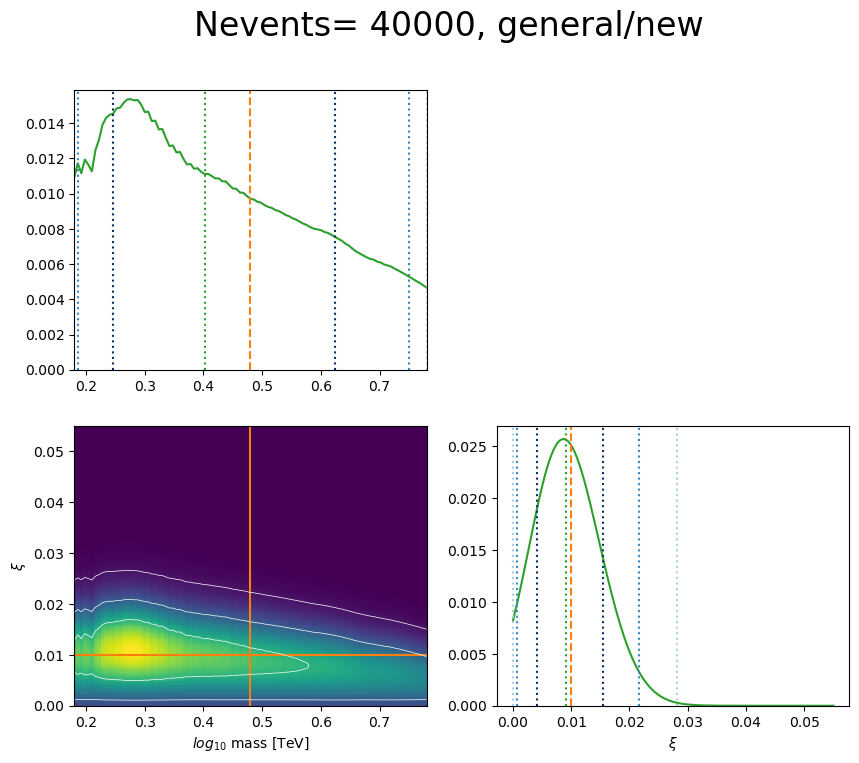

In [26]:
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {Nsamples}, general/new", size=24)

# Upper left plot
logmass_logposterior = special.logsumexp(log_posterior, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(truelogmass, ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10eaxistrue[1]-log10eaxistrue[0]:
    for logetrueval in log10eaxistrue:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(log_posterior), vmin=0)
ax[1,0].axvline(truelogmass, c='tab:orange')
ax[1,0].axhline(truelambda, c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\xi$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
normed_posterior = np.exp(log_posterior)/np.exp(log_posterior).sum()
n = 100000
t = np.linspace(0, normed_posterior.max(), n)
integral = ((normed_posterior >= t[:, None, None]) * normed_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(normed_posterior, t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


lambda_logposterior = special.logsumexp(log_posterior, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlambda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()]
    lambdapercentiles.append(lambdapercentile)
    print("l ", np.abs(lambdapercentile - meanlambda), zscore)





ax[1,1].plot(lambdarange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(truelambda, ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\xi$')
ax[1,1].set_ylim([0, None])


# plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{truelogmass}_l{truelambda}_%m%d_%H%M.pdf"))
plt.show()

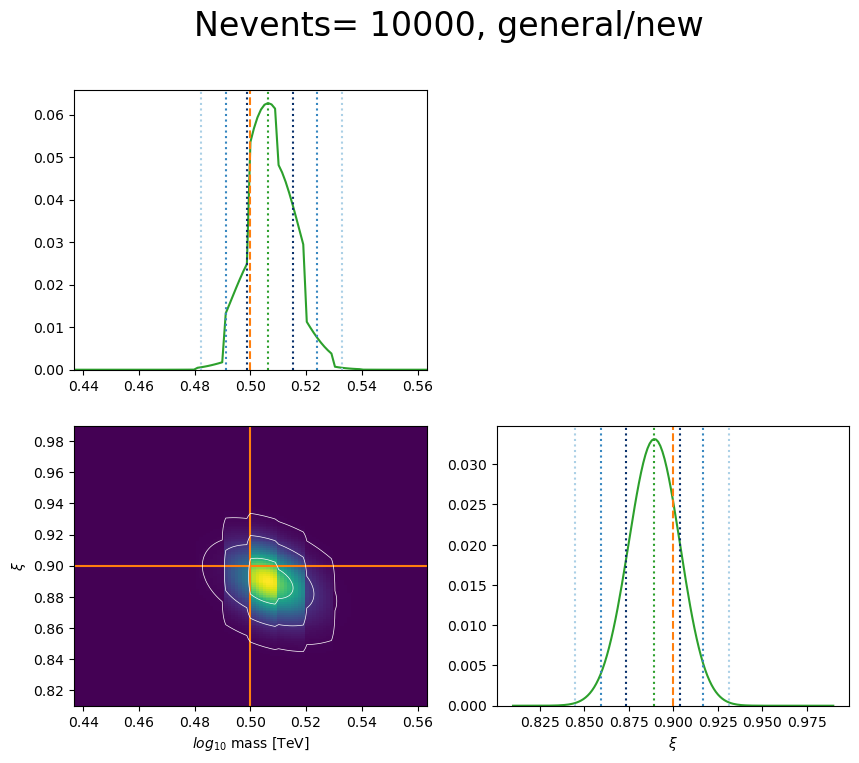

In [27]:
random.getstate()

(3,
 (1204175039,
  3532778561,
  1721133393,
  524658167,
  3211407555,
  3954903747,
  211978304,
  3908521838,
  297977671,
  995210498,
  138928807,
  370699428,
  2015059462,
  1697609067,
  820479036,
  528217608,
  2681851302,
  2585143465,
  4028581905,
  3912399530,
  158949694,
  3180042283,
  2233527041,
  3484730590,
  2644426910,
  1168639891,
  2663751664,
  642297829,
  552818368,
  2041467287,
  2118351780,
  2564062686,
  2605642279,
  3281531049,
  2347090757,
  3557573449,
  2453199839,
  3307468458,
  2283559238,
  161759023,
  3909485127,
  1981154995,
  1100852295,
  1974594121,
  910007235,
  3332196173,
  3512713420,
  2493726512,
  3857231945,
  1611066541,
  4061975338,
  1223928113,
  3341537413,
  3473648467,
  8151143,
  831794467,
  285587916,
  3951118163,
  3077720692,
  2203519202,
  3723982578,
  29465649,
  1681520085,
  2383467205,
  457381342,
  1057201504,
  120149767,
  1304747575,
  3156764610,
  2952162957,
  1574462021,
  3083138787,
  20475396